In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from tensorflow import keras

In [2]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [3]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [4]:
class AdjustedRSquared(tf.keras.losses.Loss):
    '''
    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquared().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)
        adjusted_r2 = tf.math.reduce_mean(adjusted_r2)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquared(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [5]:
#wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [6]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

# Include test data and Models

In [7]:
test_datafile_fw = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_fw1.h5'
test_datafile_iv = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_iv1.h5'



In [8]:
model_name_fw = 'forward_model/surrogate_model'
model_name_iv = 'forward_model/surrogate_model'

In [9]:
model_dir_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_fw5/models'
model_dir_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_iv5/models'


In [10]:
# Resulting plots will be stored in the fw model directory
plot_dir = model_dir_fw +'/plots/model_1'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_fw5/models/plots/model_1'

# Load the model and the data

In [11]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)


In [12]:
dvar_test = pd.read_hdf(test_datafile_iv,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile_iv,key = 'qoi')

# I just include the test_datafile_iv, because it should be the same as test_datafile_fw, just dvar and qoi are switched
# In the test datafile dvar are preprocessed already with:
# log(dvar['Vtot'],dvar['RmedianV'],dvar['GSD']-1, dvar['n']-1.33,dvar['k'])
# qoi are preprocessed with log(qoi[F11])

dvar_test_preprocessed = dvar_test.copy()
qoi_test_preprocessed = qoi_test.copy()


In [13]:
#dvar_test1 = pd.read_hdf(test_datafile_fw,key = 'dvar')
#qoi_test1 = pd.read_hdf(test_datafile_fw,key = 'qoi')


# Predict aerosol properties from phase functions

In [14]:
dvar_pred = surr_fw.predict(qoi_test_preprocessed)
dvar_pred = pd.DataFrame(data=dvar_pred, columns=dvar_test.columns)

In [15]:
dvar_pred = np.exp(dvar_pred)
dvar_pred['GSD']=dvar_pred['GSD']+1
dvar_pred['n']= dvar_pred['n']+1.33

dvar_test = np.exp(dvar_test)
dvar_test['GSD']=dvar_test['GSD']+1
dvar_test['n']=dvar_test['n']+1.33

## 1.calculate metrics

In [16]:
fw_error_df = pd.DataFrame(columns = dvar_test.columns)
fw_error_df


Empty DataFrame
Columns: [Vtot, RmedianV, GSD, n, k]
Index: []

In [17]:
# R2 value
metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_fw = metric.call(dvar_test.values, dvar_pred.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=dvar_test.columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=2)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T
r2_adj_fw

Vtot  RmedianV   GSD     n    k
0   1.0      0.99  0.99  0.99  1.0

In [18]:
fw_error_df.loc['r2']= [r2_adj_fw['Vtot'].values[0], r2_adj_fw['RmedianV'].values[0],r2_adj_fw['GSD'].values[0],r2_adj_fw['n'].values[0],r2_adj_fw['k'].values[0]]
fw_error_df


Vtot  RmedianV   GSD     n    k
r2   1.0      0.99  0.99  0.99  1.0

In [19]:
# absolute error
abs_error_fw = np.abs(dvar_test-dvar_pred)
abs_error_fw = pd.DataFrame(abs_error_fw, columns=dvar_test.columns).abs()
abs_error_fw.reset_index(drop=True, inplace=True)
abs_error_fw

Vtot   RmedianV       GSD         n         k
0       0.070652   1.266377  0.017209  0.000069  0.036620
1       0.061626  71.987477  0.026176  0.027123  0.062578
2       0.234016   2.060760  0.002042  0.019673  0.038476
3       1.503470  14.255570  0.024044  0.037483  0.066420
4      11.037609   0.726787  0.076633  0.039119  0.126318
...          ...        ...       ...       ...       ...
19464  63.421498   3.150163  0.024256  0.004838  0.010086
19465   0.063462   1.173636  0.000962  0.035198  0.039946
19466   0.132917   6.455334  0.000920  0.000647  0.014878
19467  42.308947  13.021303  0.007295  0.007756  0.007965
19468   0.096952   4.026733  0.047974  0.056405  0.006796

[19469 rows x 5 columns]

In [20]:
abs_error_table_fw = np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_fw

Vtot  RmedianV   GSD     n     k
50%    0.93      9.86  0.02  0.02  0.02
75%    8.97     35.49  0.04  0.04  0.04
90%   40.88    114.85  0.06  0.07  0.07
95%   78.47    189.35  0.08  0.09  0.09
99%  194.57    363.78  0.12  0.13  0.14

In [21]:
fw_error_df.loc['abs error 90%'] = abs_error_table_fw.loc['90%']

fw_error_df.loc['abs error 95%'] = abs_error_table_fw.loc['95%']


In [22]:
rel_error_fw = np.abs(dvar_test - dvar_pred) / dvar_test * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=dvar_test.columns).abs()
rel_error_fw.reset_index(drop=True, inplace=True)
rel_error_fw

Vtot  RmedianV       GSD         n         k
0      1.426437  0.283243  1.019870  0.002645  4.855491
1      0.625416  2.437683  0.993268  1.299006  3.501043
2      0.844825  0.809450  0.195530  0.675178  3.494061
3      3.067584  2.744377  1.100146  1.585548  3.231034
4      2.500437  0.723379  3.475022  1.356602  6.368681
...         ...       ...       ...       ...       ...
19464  2.184772  1.286734  1.183933  0.331590  2.151962
19465  1.673040  0.574331  0.079754  2.253363  3.692409
19466  1.478391  1.222420  0.047201  0.024073  0.793924
19467  1.787402  1.669201  0.285449  0.276312  1.480255
19468  0.114870  2.387873  1.859568  2.200439  0.615550

[19469 rows x 5 columns]

In [23]:
rel_error_table_fw = np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_fw

Vtot  RmedianV   GSD     n      k
50%   1.66      1.85  0.97  1.18   2.33
75%   3.01      3.13  1.78  1.96   3.93
90%   4.72      5.07  2.71  2.82   6.18
95%   6.40      6.85  3.38  3.53   8.96
99%  11.96     12.06  5.41  5.16  25.45

In [24]:
fw_error_df.loc['rel error 90%'] = rel_error_table_fw.loc['90%']

fw_error_df.loc['rel error 95%'] = rel_error_table_fw.loc['95%']
                                            

In [25]:
wMAPE_fw = wmape(dvar_test, dvar_pred)
wMAPE_fw = pd.DataFrame(wMAPE_fw).T
wMAPE_fw=np.round(wMAPE_fw, decimals =2)
wMAPE_fw

Vtot  RmedianV   GSD     n     k
0  2.56      3.16  1.36  1.51  2.68

In [26]:
fw_error_df.loc['wmape'] = [wMAPE_fw['Vtot'].values[0],wMAPE_fw['RmedianV'].values[0],wMAPE_fw['GSD'].values[0],wMAPE_fw['n'].values[0],wMAPE_fw['k'].values[0]]
fw_error_df

Vtot  RmedianV   GSD     n     k
r2              1.00      0.99  0.99  0.99  1.00
abs error 90%  40.88    114.85  0.06  0.07  0.07
abs error 95%  78.47    189.35  0.08  0.09  0.09
rel error 90%   4.72      5.07  2.71  2.82  6.18
rel error 95%   6.40      6.85  3.38  3.53  8.96
wmape           2.56      3.16  1.36  1.51  2.68

In [27]:
fw_error_df.to_csv(f'{plot_dir}/fw_error_df.csv')

## 2. plots

In [28]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [29]:
dvar_test['DmedianV']=dvar_test['RmedianV']*2*1e-3 #[um]
dvar_test['DmedianN']=(np.exp(np.log(dvar_test['DmedianV']) - (3*np.log(dvar_test['GSD'])**2))) *1e3   #[nm]
dvar_test['Ntot'] = 6 / np.pi * dvar_test['Vtot']*1e9 / (np.exp((3*np.log(dvar_test['DmedianN'])) + (4.5*np.log(dvar_test['GSD'])**2))) # [cm^-3]
 

In [30]:
dvar_pred['DmedianV']=dvar_pred['RmedianV']*2*1e-3 #[um]
dvar_pred['DmedianN']=(np.exp(np.log(dvar_pred['DmedianV']) - (3*np.log(dvar_pred['GSD'])**2))) *1e3   #[nm]
dvar_pred['Ntot'] = 6 / np.pi * dvar_pred['Vtot']*1e9 / (np.exp((3*np.log(dvar_pred['DmedianN'])) + (4.5*np.log(dvar_pred['GSD'])**2))) # [cm^-3]


In [31]:
D_array = np.logspace(1, 4.5, 200)  # [nm]
presentation_plot_index = [100,200,300,400,500]

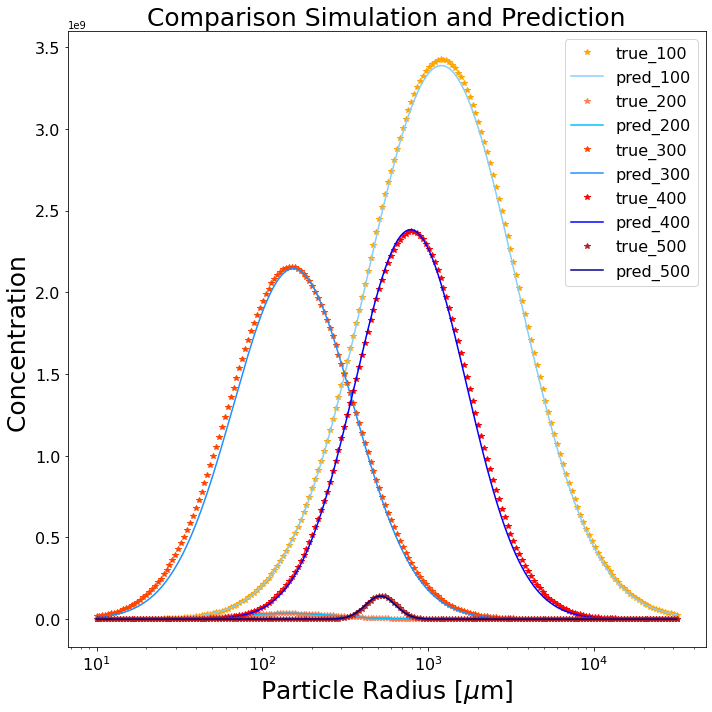

In [32]:
fig, ax = plt.subplots(figsize = (10,10))

colors_blue = ['lightskyblue','deepskyblue','dodgerblue','blue','darkblue']
colors_red = ['orange','coral','orangered','red','firebrick','darkred']

j = 0
for i  in presentation_plot_index:
    
    pdf1 = lognormal(D_array, dvar_test['DmedianN'].loc[i], dvar_test['GSD'].loc[i], dvar_test['Ntot'].loc[i])
    pdf2 = lognormal(D_array, dvar_pred['DmedianN'].loc[i], dvar_pred['GSD'].loc[i], dvar_pred['Ntot'].loc[i])
    
    ax.plot(D_array, pdf1*4/3.*np.pi*D_array**3., '*', color = colors_red[j], label = 'true_'+str(i))
    
    ax.plot(D_array, pdf2*4/3.*np.pi*D_array**3., color = colors_blue[j], label = 'pred_'+str(i))
    


    ax.legend(fontsize = 16)   
    j = j+1
ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/size_distribution_true_pred.jpg')

## 3. plot the biggest error 

In [33]:
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [34]:
testGSD1 = rel_error_fw['GSD'].values
testR = rel_error_fw['RmedianV'].values
testn = rel_error_fw['n'].values
testk = rel_error_fw['k'].values
testVtot = rel_error_fw['Vtot'].values
testGSD2 = np.log(dvar_test['RmedianV'].values)
testGSD3 = np.log(dvar_test['GSD'].values)


In [35]:
grid_x, grid_y = np.mgrid[100:5001:1, 1.01:3.1:0.01]

grid_x = np.log(grid_x)
grid_y = np.log(grid_y)
grid_GSD = griddata((testGSD2,testGSD3), testGSD1, (grid_x, grid_y), method='nearest')
grid_R = griddata((testGSD2,testGSD3), testR, (grid_x, grid_y), method='nearest')
grid_Vtot = griddata((testGSD2,testGSD3), testVtot, (grid_x, grid_y), method='nearest')
grid_n = griddata((testGSD2,testGSD3), testn, (grid_x, grid_y), method='nearest')
grid_k = griddata((testGSD2,testGSD3), testk, (grid_x, grid_y), method='nearest')


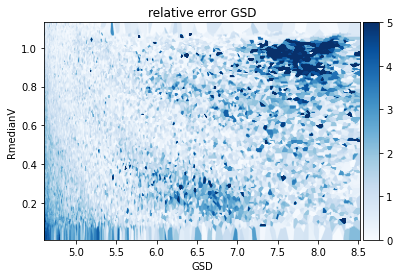

In [36]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_GSD.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error GSD')
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errGSD_GSD_R.jpg')

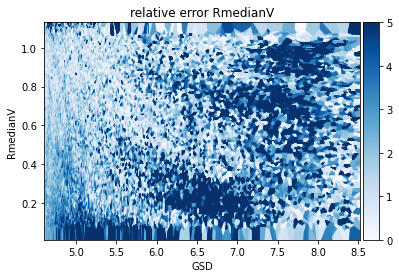

In [37]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_R.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error RmedianV')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errR_GSD_R.jpg')

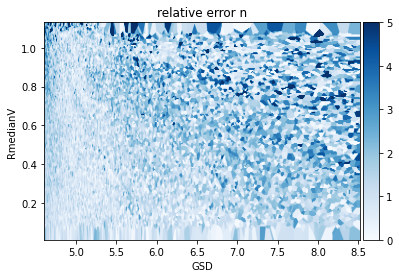

In [38]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_n.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error n')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errn_GSD_R.jpg')

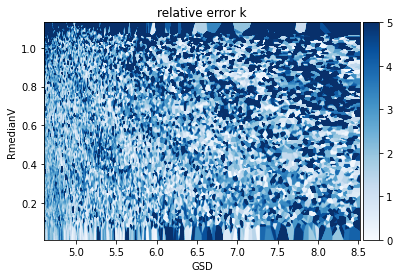

In [39]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_k.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error k')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errk_GSD_R.jpg')

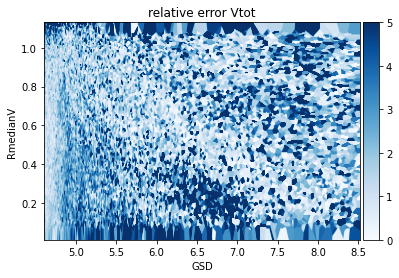

In [40]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_Vtot.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error Vtot')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errVtot_GSD_R.jpg')

# Predict phase functions from aerosol properties

In [41]:
qoi_pred = surr_iv.predict(dvar_test_preprocessed)
qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_test.columns)

In [42]:
F11_columns = [x for x in qoi_test.columns if 'F11' in x]
PPF_columns = [x for x in qoi_test.columns if 'PPF' in x]

In [43]:
qoi_test[F11_columns] = np.exp(qoi_test[F11_columns])
qoi_pred[F11_columns] = np.exp(qoi_pred[F11_columns])


In [44]:
## 1. calculate metrics

In [45]:
metric = RSquaredSeparated()
r2_adj_iv = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=qoi_test.columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T
print('Forward model: ','R2_min = ', min(r2_adj_iv.min()),';  R2_max = ', max(r2_adj_iv.max()))
r2_adj_iv

Forward model:  R2_min =  0.85 ;  R2_max =  1.0


F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

   F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  PPF_167  \
0     1.0  ...      0.9     0.89     0.88     0.87     0.86     0.86     0.87   

   PPF_168  PPF_169  PPF_170  
0     0.87     0.86     0.85  

[1 rows x 304 columns]

In [46]:
iv_error_df = pd.DataFrame(columns = ['F11','PPF'])
iv_error_df.loc['r2']= [np.mean(r2_adj_iv[F11_columns].mean()),np.mean(r2_adj_iv[PPF_columns].mean())]
iv_error_df

F11       PPF
r2  0.999868  0.984408

In [47]:
r2_adj_iv.values

array([[1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 

In [48]:
abs_error_iv = np.abs(qoi_pred - qoi_test)
abs_error_iv

F11_10      F11_11      F11_12     F11_13     F11_14     F11_15  \
0        0.222332    0.263039    0.256334   0.258181   0.228280   0.195460   
1        0.309387    0.198353    0.112836   0.049703   0.016267   0.000241   
2       10.711139    8.846568    6.183475   3.329808   0.822791   1.502080   
3        2.446181    3.254863    3.004572   2.582935   2.193204   1.990759   
4       35.454506   25.712983   15.384463  10.123338   5.959628   6.050408   
...           ...         ...         ...        ...        ...        ...   
19464  102.757037  125.386781  110.661556  96.203954  70.290190  48.401923   
19465    0.270582    0.098300    0.084234   0.201507   0.329250   0.411469   
19466    0.049876    0.064024    0.115628   0.132311   0.151722   0.158646   
19467    5.236982   28.686138   24.076237   5.316988   9.386904  22.468977   
19468    2.145283    0.933839    0.224616   0.439975   0.322645   0.280998   

          F11_16     F11_17     F11_18     F11_19  ...   PPF_161   PPF_162  \
0       0.146307   0.105311   0.065322   0.027849  ...  0.000334  0.000457   
1       0.005203   0.004727   0.001346   0.001573  ...  0.000063  0.000068   
2       3.283213   4.512400   5.309701   5.646154  ...  0.018567  0.016588   
3       1.870502   1.785280   1.593188   1.358463  ...  0.000399  0.000379   
4       6.691365   7.256526   5.929365   4.742116  ...  0.001668  0.001513   
...          ...        ...        ...        ...  ...       ...       ...   
19464  24.840568   4.914239  20.963068  45.207409  ...  0.000460  0.001040   
19465   0.465463   0.469601   0.454687   0.410221  ...  0.005428  0.005092   
19466   0.159435   0.164945   0.168656   0.151449  ...  0.000156  0.000065   
19467  30.500839  33.962129  34.249695  35.488951  ...  0.000645  0.000870   
19468   0.130226   0.016443   0.032553   0.193412  ...  0.000184  0.000182   

        PPF_163   PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169  \
0      0.000584  0.000693  0.000866  0.001018  0.001224  0.001293  0.001252   
1      0.000053  0.000057  0.000027  0.000107  0.000217  0.000323  0.000429   
2      0.014869  0.013424  0.012103  0.010806  0.009569  0.008324  0.007241   
3      0.000278  0.000157  0.000141  0.000081  0.000144  0.000154  0.000114   
4      0.001455  0.001367  0.001104  0.000939  0.000466  0.000044  0.000296   
...         ...       ...       ...       ...       ...       ...       ...   
19464  0.001493  0.001917  0.002453  0.002866  0.003367  0.003631  0.003646   
19465  0.004523  0.004026  0.003737  0.003149  0.002837  0.002432  0.002116   
19466  0.000011  0.000020  0.000050  0.000144  0.000205  0.000203  0.000162   
19467  0.001037  0.001205  0.001288  0.001152  0.000989  0.000810  0.000645   
19468  0.000211  0.000327  0.000390  0.000242  0.000184  0.000105  0.000003   

        PPF_170  
0      0.001159  
1      0.000502  
2      0.006359  
3      0.000124  
4      0.000679  
...         ...  
19464  0.003541  
19465  0.002128  
19466  0.000093  
19467  0.000519  
19468  0.000059  

[19469 rows x 304 columns]

In [49]:
abs_error_table_iv =  np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    1.74    1.24    0.95    0.83    0.75    0.66    0.59    0.54    0.47   
75%   16.31   11.51    8.91    7.96    7.09    6.51    5.88    5.36    4.70   
90%   79.89   57.70   46.06   41.83   38.11   35.22   32.80   29.75   26.92   
95%  166.48  126.76  102.60   90.94   83.12   78.33   72.52   67.93   61.97   
99%  466.02  374.86  331.31  300.50  265.38  241.83  224.03  205.66  193.88   

     F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  \
50%    0.41  ...     0.00     0.00     0.00     0.00     0.00     0.00   
75%    4.08  ...     0.00     0.00     0.00     0.00     0.00     0.00   
90%   23.97  ...     0.00     0.00     0.00     0.00     0.00     0.00   
95%   55.77  ...     0.01     0.01     0.01     0.01     0.01     0.01   
99%  186.48  ...     0.02     0.02     0.02     0.02     0.02     0.02   

     PPF_167  PPF_168  PPF_169  PPF_170  
50%     0.00     0.00     0.00     0.00  
75%     0.00     0.00     0.00     0.00  
90%     0.00     0.00     0.00     0.00  
95%     0.01     0.01     0.01     0.01  
99%     0.02     0.02     0.02     0.02  

[5 rows x 304 columns]

In [50]:
iv_error_df.loc['abs error 90%']=[abs_error_table_iv[F11_columns].loc['90%'].max(), abs_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['abs error 95%']=[abs_error_table_iv[F11_columns].loc['95%'].max(), abs_error_table_iv[PPF_columns].loc['95%'].max()]


In [51]:
rel_error_iv = abs_error_iv / qoi_test * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=qoi_test.columns).abs()
rel_error_iv

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0       1.114276  1.438604  1.533967  1.694097  1.645089  1.548858  1.275888   
1       3.850048  3.065323  2.134754  1.136689  0.444613  0.007783  0.197170   
2      10.431169  8.812816  6.314737  3.493538  0.888792  1.674207  3.784091   
3       1.394900  2.061472  2.109294  2.005651  1.879593  1.878853  1.939852   
4       3.686779  2.726941  1.665548  1.119720  0.673960  0.700020  0.792503   
...          ...       ...       ...       ...       ...       ...       ...   
19464   1.309367  1.689345  1.578566  1.454538  1.127367  0.824070  0.449180   
19465   2.254048  0.833015  0.727306  1.775605  2.965520  3.794200  4.401099   
19466   0.149312  0.213427  0.428944  0.545696  0.694840  0.805609  0.896298   
19467   0.082267  0.512533  0.486646  0.120984  0.239360  0.639374  0.964786   
19468   0.910120  0.414212  0.104171  0.213337  0.163543  0.148865  0.072088   

         F11_17    F11_18    F11_19  ...    PPF_161    PPF_162    PPF_163  \
0      1.011208  0.690793  0.324346  ...   1.012030   1.501582   2.091783   
1      0.208181  0.068325  0.091453  ...   0.338157   0.399081   0.341006   
2      5.389597  6.586340  7.289363  ...  55.508533  49.357171  44.973706   
3      2.030045  1.982065  1.845123  ...   1.160985   1.195840   0.955310   
4      0.880227  0.736967  0.604164  ...   3.815948   3.846605   4.136545   
...         ...       ...       ...  ...        ...        ...        ...   
19464  0.094415  0.428048  0.981254  ...   0.744207   1.862757   2.976213   
19465  4.560143  4.541634  4.221225  ...   9.287193   9.587263   9.437485   
19466  1.024814  1.156024  1.143098  ...   0.516142   0.231334   0.041348   
19467  1.189817  1.324421  1.509922  ...   1.913052   2.830656   3.725979   
19468  0.009508  0.019657  0.121925  ...   0.370843   0.405202   0.524252   

         PPF_164    PPF_165    PPF_166    PPF_167    PPF_168    PPF_169  \
0       2.727382   3.774720   4.968091   6.759274   8.184022   9.228223   
1       0.404621   0.216219   0.952363   2.171895   3.698106   5.677367   
2      42.083396  40.055881  38.441735  37.259404  36.151217  35.793734   
3       0.594687   0.592413   0.380353   0.764338   0.931364   0.804310   
4       4.375869   4.012199   3.910082   2.245652   0.246939   1.986113   
...          ...        ...        ...        ...        ...        ...   
19464   4.282697   6.189920   8.246221  11.162200  14.040253  16.677545   
19465   9.379454   9.805372   9.395038   9.728075   9.705629   9.973289   
19466   0.086178   0.229978   0.742678   1.188516   1.343305   1.235184   
19467   4.814267   5.770567   5.844149   5.740430   5.445506   5.096599   
19468   0.914623   1.235101   0.876900   0.768900   0.511398   0.016247   

         PPF_170  
0      10.125773  
1       7.813291  
2      36.575160  
3       1.036971  
4       5.493730  
...          ...  
19464  19.489295  
19465  12.055279  
19466   0.840118  
19467   4.899138  
19468   0.414544  

[19469 rows x 304 columns]

In [52]:
rel_error_table_iv = np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    1.69    1.40    1.25    1.26    1.26    1.28    1.27    1.27    1.24   
75%    3.10    2.60    2.37    2.34    2.31    2.31    2.31    2.34    2.30   
90%    5.17    4.40    3.98    3.91    3.89    3.89    3.93    3.98    3.86   
95%    7.30    6.24    5.61    5.41    5.50    5.69    5.74    5.76    5.56   
99%   16.22   15.07   13.41   12.28   12.91   13.02   13.06   13.02   12.28   

     F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  \
50%    1.21  ...     3.13     3.39     3.69     4.07     4.38     4.49   
75%    2.21  ...     6.28     6.79     7.35     7.99     8.47     8.69   
90%    3.74  ...    12.30    13.07    13.97    15.03    15.86    16.37   
95%    5.42  ...    21.79    22.77    23.76    24.72    24.73    25.43   
99%   12.53  ...    97.78    99.94    94.38    97.97    99.78   100.24   

     PPF_167  PPF_168  PPF_169  PPF_170  
50%     4.59     4.84     5.33     6.18  
75%     9.08     9.82    11.11    13.20  
90%    16.95    18.24    20.89    25.64  
95%    26.48    27.94    33.27    41.79  
99%   103.98   106.16   111.56   120.71  

[5 rows x 304 columns]

In [53]:
iv_error_df.loc['rel error 90%']=[rel_error_table_iv[F11_columns].loc['90%'].max(), rel_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['rel error 95%']=[rel_error_table_iv[F11_columns].loc['95%'].max(), rel_error_table_iv[PPF_columns].loc['95%'].max()]


In [54]:

abs_error_table_F11 = abs_error_table_iv[F11_columns]
print('Absolute error F11')
print(abs_error_table_F11.max(axis = 1))
abs_error_table_PPF = abs_error_table_iv[PPF_columns]
print('Absolute error PPF')
print(abs_error_table_PPF.max(axis = 1))
rel_error_table_F11 = rel_error_table_iv[F11_columns]
print('Relative error F11')
print(rel_error_table_F11.max(axis = 1))
rel_error_table_PPF = rel_error_table_iv[PPF_columns]
print('Relative error PPF')
print(rel_error_table_PPF.max(axis = 1))


Absolute error F11
50%      1.74
75%     16.31
90%     79.89
95%    166.48
99%    466.02
dtype: float64
Absolute error PPF
50%    0.00
75%    0.00
90%    0.01
95%    0.01
99%    0.04
dtype: float64
Relative error F11
50%     1.69
75%     3.10
90%     5.17
95%     7.30
99%    16.22
dtype: float64
Relative error PPF
50%      6.18
75%     13.20
90%     25.64
95%     41.79
99%    257.73
dtype: float64


In [55]:
wMAPE_qoi = wmape(qoi_test, qoi_pred)
wMAPE_qoi = pd.DataFrame(wMAPE_qoi).T
np.round(wMAPE_qoi, decimals =2)

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0    2.39    2.03    1.83    1.79     1.8    1.81    1.82    1.83    1.82   

   F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  PPF_167  \
0     1.8  ...     6.55      7.0     7.51     8.05     8.51     8.87     9.32   

   PPF_168  PPF_169  PPF_170  
0     9.99    11.13    12.91  

[1 rows x 304 columns]

In [56]:
iv_error_df.loc['wmape']=[wMAPE_qoi[F11_columns].mean().mean(),wMAPE_qoi[PPF_columns].mean().mean()]
iv_error_df

F11        PPF
r2               0.999868   0.984408
abs error 90%   79.890000   0.010000
abs error 95%  166.480000   0.010000
rel error 90%    5.170000  25.640000
rel error 95%    7.300000  41.790000
wmape            1.517055   2.252747

In [57]:
iv_error_df.to_csv(f'{plot_dir}/iv_error_df.csv')

## 2. plots

In [58]:
theta = []
for i in range(10,86):
    theta.append(i)
for i in range(95,171):
    theta.append(i)

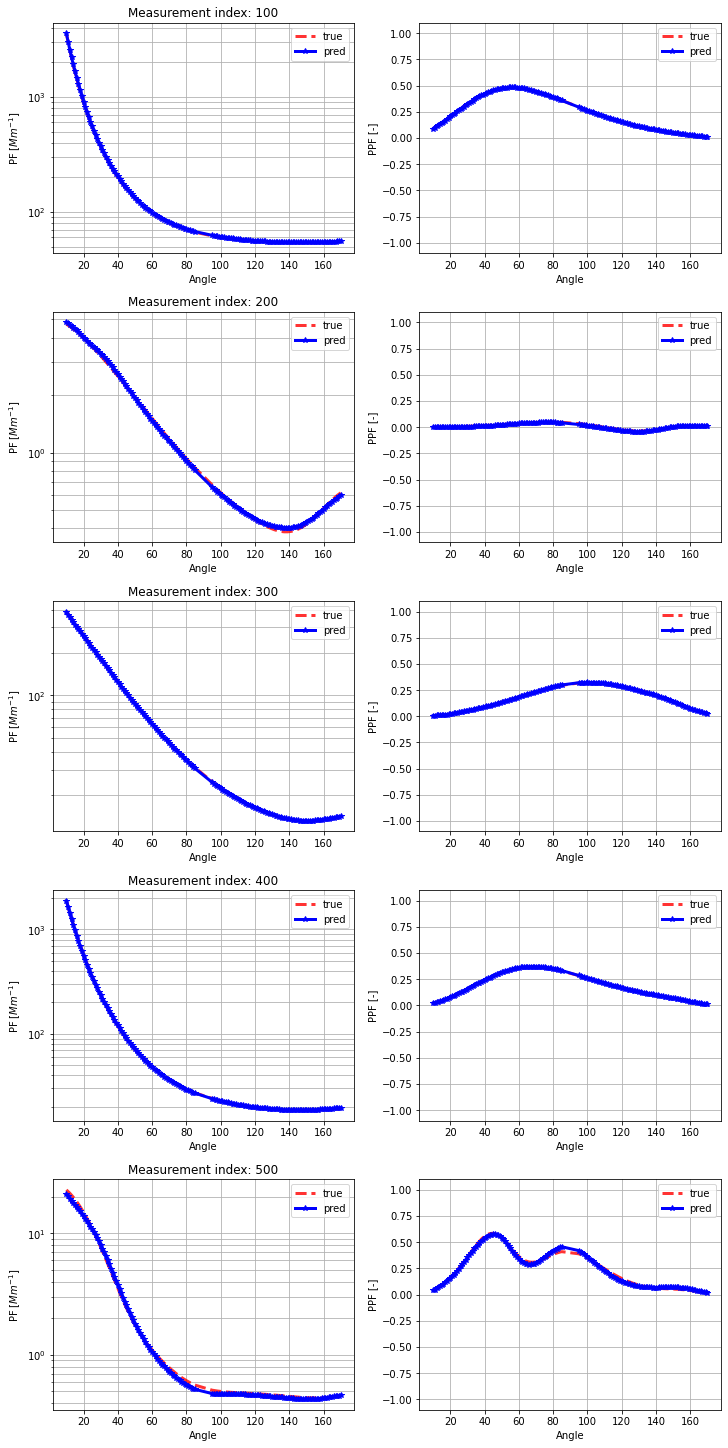

In [59]:
presentation_plot_index = [100,200,300,400,500]
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 20), constrained_layout=True)
nr = 0
for index in presentation_plot_index:
    axs[nr,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[nr,0].plot(theta, qoi_test[F11_columns].loc[index], ls='--', markersize = 5, lw='3', c='r', alpha=0.8, label='true')
    pms_hdf_plot, = axs[nr,1].plot(theta, qoi_test[PPF_columns].loc[index], ls='--', lw='3', c='r', alpha=0.8, label='true')

    meas_hdf_plot, = axs[nr,0].plot(theta, qoi_pred[F11_columns].loc[index],'*',ls = '-',lw ='3', c= 'b', label = 'pred')
    meas_hdf_plot, = axs[nr,1].plot(theta, qoi_pred[PPF_columns].loc[index],'*',ls = '-',lw ='3', c= 'b', label = 'pred')
    

    axs[nr,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[nr,1].set_ylabel('PPF [-]')
    axs[nr,1].set_ylim(-1.1, 1.1)
    axs[nr,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot])
        ax.grid(which='both')
    nr = nr+1
fig.savefig(f'{plot_dir}/phase_functions_true_pred.jpg')